# Retrieval of the TOA Reflectance from the MYD02HKM data

The SARA is based on the satellite received spectral reflectance (ρλ), which is a func- tion of measured spectral radiance (LTOA(λ)), solar zenith angle, earth–sun distance in astronomical unit and mean solar exoatmospheric radiation (Eq. 1):

$\rho_{TOA(\lambda)} = \frac{\pi L_{TOA(\lambda)}d^2}{ESUN_{\lambda}\mu_s}$

where $\rho_{TOA(\lambda)}$ = satellite received TOA spectral reflectance, $L_{TOA(\lambda)}$ = satellite received TOA spectral radiance, $ESUN_{\lambda}$ = mean solar exoatmospheric radiation radiation as a function of MODIS band number. For MODIS band 4, the $ESUN_{\lambda}$ value is 1850 (*Tasumi et al., 2008*). $μ_s$ = cosine of solar zenith angle.

Parameter $d^2$ can be calculated as a function of day of year using Duffie and Beckman 􏰀1991􏰁 (Eq. 2):

$d^2 = \frac{1}{1+0.033 \cos(DOY\cdot 2\pi /365)}$

where $DOY$ = day of year and 􏰀$DOY·2􏰘/365􏰁$ 􏰀(rad􏰁)


In [10]:
%matplotlib inline
import readData as rd
import math
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

## Load Data

In [11]:
# MYD02HKM = rd.read_data3('MYD02HKM')
# MYD03 = rd.read_data('MYD03')
# MYD02_E_LUTs = rd.read_data('MYD02_Emissive_LUTs', LUT_mode=True)
# MYD02_R_LUTs = rd.read_data('MYD02_Reflective_LUTs', LUT_mode=True)
# MYD02_Q_LUTs = rd.read_data('MYD02_QA_LUTs', LUT_mode=True)
# MYD09GA = rd.read_data('MYD09GA')

MYD02HKM = rd.read_MYD02(4)
MYD02HKM_para = rd.read_parameters_from_MYD02_HDF()



MYD02_Mosaic/MYD02HKM.A2019298.2045.tif
MYD02_Mosaic/MYD02HKM.A2019299.2130.tif
MYD02_Mosaic/MYD02HKM.A2019308.2120.tif
MYD02_Mosaic/MYD02HKM.A2019304.2145.tif
MYD02_Mosaic/MYD02HKM.A2019309.2025.tif
MYD02_Mosaic/MYD02HKM.A2019301.2115.tif
MYD02_Mosaic/MYD02HKM.A2019302.2020.tif
MYD02_Mosaic/MYD02HKM.A2019305.2050.tif
MYD02_Mosaic/MYD02HKM.A2019303.2105.tif
MYD02_Mosaic/MYD02HKM.A2019307.2040.tif
MYD02_Mosaic/MYD02HKM.A2019300.2030.tif
MYD02_Mosaic/MYD02HKM.A2019306.2135.tif
MYD02HKM_hdf/MYD02HKM.A2019299.2130.061.2019300153603.psgscs_000501391352.hdf
MYD02HKM_hdf/MYD02HKM.A2019302.2020.061.2019303155337.psgscs_000501391352.hdf
MYD02HKM_hdf/MYD02HKM.A2019306.2135.061.2019307150842.psgscs_000501391352.hdf
MYD02HKM_hdf/MYD02HKM.A2019300.2030.061.2019301152343.psgscs_000501391352.hdf
MYD02HKM_hdf/MYD02HKM.A2019301.2115.061.2019302151923.psgscs_000501391352.hdf
MYD02HKM_hdf/MYD02HKM.A2019309.2025.061.2019310152027.psgscs_000501391352.hdf
MYD02HKM_hdf/MYD02HKM.A2019302.2200.061.201930315395

In [12]:
# print('--- MYD02 Reflective LUTs ---')
# for item in MYD02_R_LUTs[0]['dataset_list']:
#     print(item[1])

According to the LUT provided by the MODIS Characterization Support Team (MCST), the data in scaled integer bands should be converted. 

For MODIS band 4, the values of the DN are scaled from \[0, 4095\] to \[0, 32767]. In this regard, we need to covert the data back to its correct values. 

In [13]:
# data02 = MYD02HKM[3]['data']
# lon = MYD02HKM[0]['lon']
# lat = MYD02HKM[0]['lat']
year = MYD02HKM[3]['year']
dofy = MYD02HKM[3]['dofy']
hour = MYD02HKM[3]['hour']
minute = MYD02HKM[3]['minute']


## Importing Geolocation information in MYD03 dataset

NYD03 data provides geolocation information for MODIS products. We need to select the matching MYD03 data and make them align with the MYD02 dataset for convenience in processing. 

In [14]:
sensorAzimuth, senAzFile = rd.read_MYD03(year, dofy, hour, minute, 'SensorAzimuth')
sensorZenith, senZnFile = rd.read_MYD03(year, dofy, hour, minute, 'SensorZenith')
solarAzimuth, solAzFile = rd.read_MYD03(year, dofy, hour, minute, 'SolarAzimuth')
solarZenith, solZnFile = rd.read_MYD03(year, dofy, hour, minute, 'SolarZenith')

rd.alignRaster(MYD02HKM[3]['data'], sensorAzimuth, 
               'MYD03/MYD03_SensorAzimuth/{:04d}{:03d}{:02d}{:02d}.SenAz.tif'
               .format(year, dofy, hour, minute))
rd.alignRaster(MYD02HKM[3]['data'], sensorZenith, 
               'MYD03/MYD03_SensorZenith/{:04d}{:03d}{:02d}{:02d}.SenZe.tif'
               .format(year, dofy, hour, minute))
rd.alignRaster(MYD02HKM[3]['data'], solarAzimuth, 
               'MYD03/MYD03_SolarAzimuth/{:04d}{:03d}{:02d}{:02d}.SolAz.tif'
               .format(year, dofy, hour, minute))
rd.alignRaster(MYD02HKM[3]['data'], solarZenith, 
               'MYD03/MYD03_SolarZenith/{:04d}{:03d}{:02d}{:02d}.SolZe.tif'
               .format(year, dofy, hour, minute))



MYD02HKM = rd.preprocess_MYD02(MYD02HKM, MYD02HKM_para)

MYD03/MYD03.A2019301.2115.061.2019302151225.pssgrpgs_000501393055.SensorAzimuth-SensorAzimuth.tif
MYD03/MYD03.A2019301.2115.061.2019302151225.pssgrpgs_000501393055.SensorZenith-SensorZenith.tif
MYD03/MYD03.A2019301.2115.061.2019302151225.pssgrpgs_000501393055.SolarAzimuth-SolarAzimuth.tif
MYD03/MYD03.A2019301.2115.061.2019302151225.pssgrpgs_000501393055.SolarZenith-SolarZenith.tif


## Data Exploration

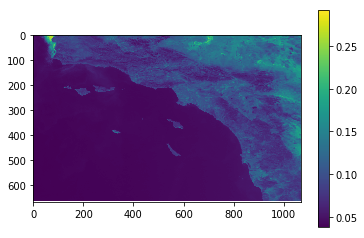

In [15]:
# data02 = data02.ReadAsArray()
plt.imshow(MYD02HKM[1]['data'])
plt.colorbar()

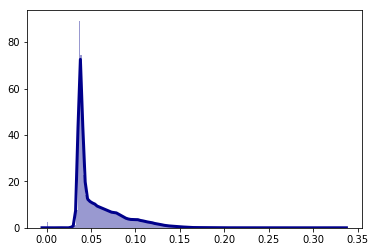

In [16]:
rd.show_histogram(MYD02HKM[5]['data'], masked=True)


In [17]:
d2 = 2 * math.pi * dofy / 365
d2 = 0.033 * math.cos(d2) + 1
d2 = 1 / d2
print("d^2 = ", d2)
ESUN = 1850
print('ESUN = ', ESUN)
# µ_v = pd.DataFrame(np.cos(solarZenith.values / 180 * math.pi / 100))
µ_s = np.cos(solarZenith)
µ_v = np.cos(sensorZenith)

d^2 =  0.9853009040099944
ESUN =  1850


In [18]:
# rho_TOA = math.pi * data02 * d2 / (ESUN * µ_s)
# rd.show_histogram(rho_TOA)

NameError: name 'data02' is not defined

In [ ]:
# plt.imshow(rho_TOA)
# plt.colorbar()

# Rayleigh Reflectance

### **Calculating the scattering Angle**

According to [Levy et. al](https://doi.org/10.1029/2006JD007811), the scattering angle could be calculated from the following function:

$\Theta = \cos^{-1} (-\cos \theta_0\cos\theta + \sin \theta_0 \sin \theta \cos \phi)$

where $θ_0$, $θ$, and $ϕ$ are the **solar zenith**, **sensor view zenith**, and **relative azimuth angles**, respectively. 
Relative azimuth could be computed by using this function:

$\phi = sensor_{az} - solar_{az} - 180$
http://oceancolor.gsfc.nasa.gov/forum/oceancolor/topic_show.pl?pid=12697;hl=scattering%20angle#pid12697

The Rayleigh reflectance could be calculated from the following equation:
> Bilal, M.; Nazeer, M.; Nichol, J.E.; Bleiweiss, M.P.; Qiu, Z.; Jäkel, E.; Campbell, J.R.; Atique, L.; Huang, X.; Lolli, S. A Simplified and Robust Surface Reflectance Estimation Method (SREM) for Use over Diverse Land Surfaces Using Multi-Sensor Data. Remote Sens. 2019, 11, 1344.

$\rho_R = P_R \cdot \frac{1 - e^{-M\tau_r}}{4(\mu_s + \mu_v)}$

where M = air mass = $\frac1{\mu_s}+ \frac1{\mu_v}$, 

$\tau_r$ = Rayleigh optical depth = $0.008569\lambda^{-4}(1 + 0.0113\lambda^{-2} + 0.0013\lambda^{-4})$, $\lambda$ is in radian; 

$P_R$ is the Rayleigh phase function = $\frac{3A}{4+B}(1 + \cos^2\Theta)$;

A and B are coefficients that account for the molecular asymmetry: $A = 0.9587256,\ B = 1−A$



                  0
count  1.781550e+05
mean   1.434195e+16
std    2.977309e+18
min   -3.201617e+10
25%   -6.110566e-02
50%    2.529019e-02
75%    6.172021e-02
max    7.414387e+20


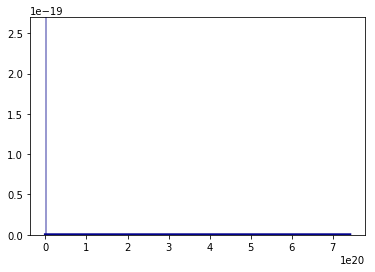

In [19]:
phi = sensorZenith - solarAzimuth - math.pi
cos_phi = np.cos(phi)
cos_Theta = -np.cos(solarZenith) * np.cos(sensorZenith) + np.sin(solarZenith) * np.sin(sensorZenith) * cos_phi
P_R = 3 * 0.9587256 / (5 - 0.9587256) * (1 + cos_Theta * cos_Theta)
wavelen = 0.555
tau_r = 0.008569 * math.pow(wavelen, -4) * (1 + 0.0113 * math.pow(wavelen, -2) + 0.0013 * math.pow(wavelen, -4))
M = 1/µ_v + 1/µ_s
rho_Ray = P_R * (1 - np.power(math.e, - M * tau_r)) / (4 * (µ_s + µ_v))

rd.show_descriptives(rho_Ray)
rd.show_histogram(rho_Ray)

In [ ]:
plt.imshow(rho_Ray)
plt.colorbar()


In [ ]:
rd.show_histogram(rho_TOA - rho_Ray)



## Using Fixed Point Iteration Methods to retrieve the coefficients

The value of AOD is determined with the following equation:
$
\tau_{\alpha} = \frac{4\mu_s\mu_v}{\omega_0P_\alpha}[\rho_{TOA}-\rho_{Ray}-\frac{e^{-(\tau_R+\tau_\alpha)/\mu_s}e^{(\tau_R+\tau_\alpha)/\mu_v}\rho_s}{1-\rho_s(0.92\tau_R+(1-g)\tau_\alpha)e^{-(\tau_R+\tau_\alpha)}}]
$
However, the single scattering albedo $\omega_0$ and the relative dominance of forward/back scattering $g$ remains unknown in this equation. Empirically we adopt the fixed point iteration (FPI) methods to solve these two terms for the day. We will iteratively varing the value of $\omega$ and $g$ until the match is obtained. 






